<a href="https://www.kaggle.com/code/adrienmorel97/eda-lightgbm-optuna-1-0644-v1?scriptVersionId=210896839" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


In [2]:
!pip install -q scikit-learn==1.5.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.9.2 which is incompatible.


In [3]:
import sklearn
sklearn.__version__

'1.5.2'

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import root_mean_squared_log_error,mean_squared_error, mean_absolute_error, r2_score

import optuna
import lightgbm as lgb

In [5]:
train_df=pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv')
test_df=pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv')

In [6]:
train_df.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [8]:
train_df.describe().round(2)

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount
count,1200000.00,1181295.00,1155051.00,1090328.00,1125924.00,835971.00,1199994.00,1062118.00,1199999.00,1200000.00
mean,599999.50,41.15,32745.22,2.01,25.61,1.00,9.57,592.92,5.02,1102.54
std,346410.31,13.54,32179.51,1.42,12.20,0.98,5.78,149.98,2.59,865.00
min,0.00,18.00,1.00,0.00,2.01,0.00,0.00,300.00,1.00,20.00
25%,299999.75,30.00,8001.00,1.00,15.92,0.00,5.00,468.00,3.00,514.00
50%,599999.50,41.00,23911.00,2.00,24.58,1.00,10.00,595.00,5.00,872.00
75%,899999.25,53.00,44634.00,3.00,34.53,2.00,15.00,721.00,7.00,1509.00
max,1199999.00,64.00,149997.00,4.00,58.98,9.00,19.00,849.00,9.00,4999.00


In [9]:
train_df.isnull().sum()


id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

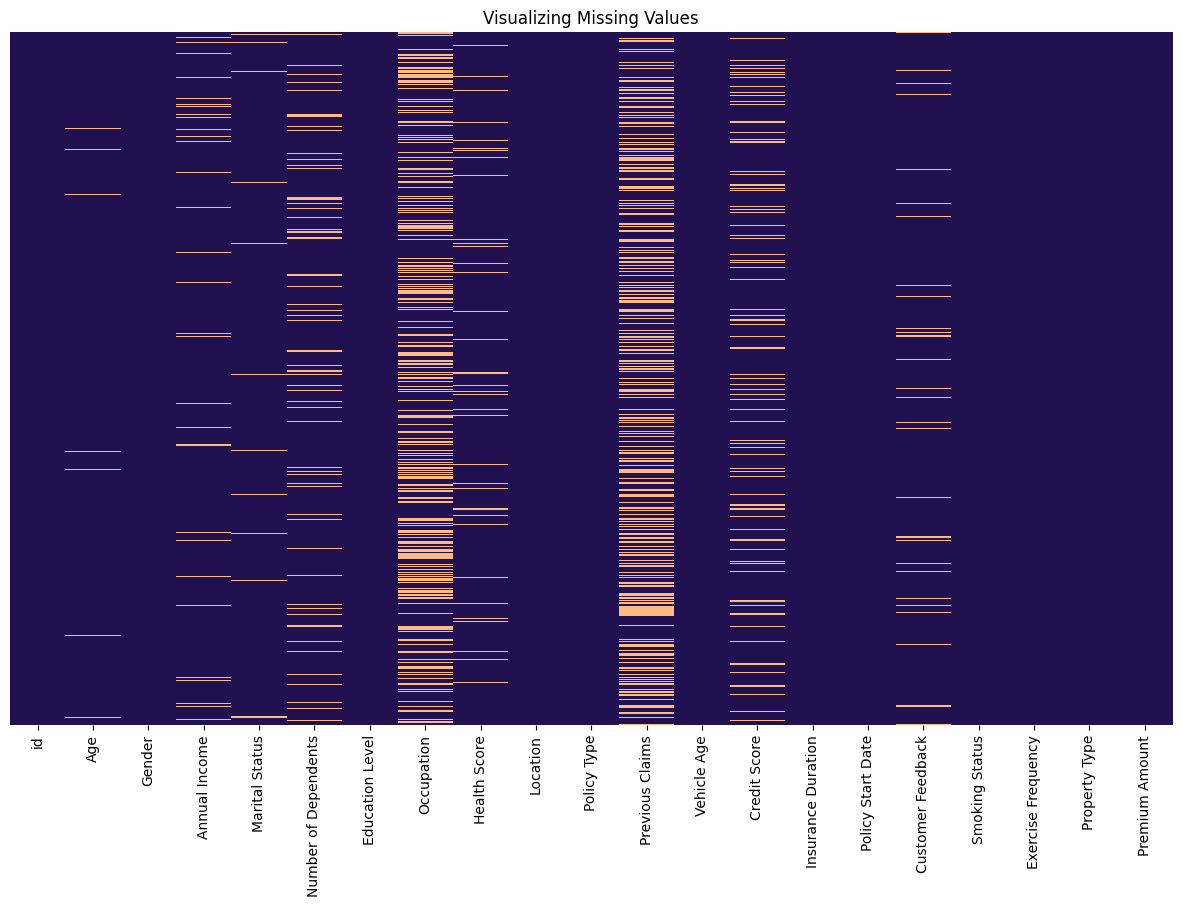

In [10]:
plt.figure(figsize=(15,9))
plt.title("Visualizing Missing Values")
sns.heatmap(train_df.isnull(), cbar=False, cmap=sns.color_palette('magma'), yticklabels=False);
plt.show()

In [11]:
# Save 'id' column for submission
test_ids = test_df['id']

# Define the target column
target_column = 'Premium Amount'

# Select categorical and numerical columns (initial)
categorical_columns = train_df.select_dtypes(include=['object']).columns
numerical_columns = train_df.select_dtypes(exclude=['object']).columns

# Print out column information
print("Target Column:", target_column)
print("\nCategorical Columns:", categorical_columns.tolist())
print("\nNumerical Columns:", numerical_columns.tolist())

Target Column: Premium Amount

Categorical Columns: ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Policy Start Date', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']

Numerical Columns: ['id', 'Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Premium Amount']


In [12]:
for column in categorical_columns:
    num_unique = train_df[column].nunique()
    print(f"'{column}' has {num_unique} unique categories.")

'Gender' has 2 unique categories.
'Marital Status' has 3 unique categories.
'Education Level' has 4 unique categories.
'Occupation' has 3 unique categories.
'Location' has 3 unique categories.
'Policy Type' has 3 unique categories.
'Policy Start Date' has 167381 unique categories.
'Customer Feedback' has 3 unique categories.
'Smoking Status' has 2 unique categories.
'Exercise Frequency' has 4 unique categories.
'Property Type' has 3 unique categories.


In [13]:
# Print top 10 unique value counts for each categorical column
for column in categorical_columns:
    print(f"\nTop value counts in '{column}':\n{train_df[column].value_counts().head(10)}")


Top value counts in 'Gender':
Gender
Male      602571
Female    597429
Name: count, dtype: int64

Top value counts in 'Marital Status':
Marital Status
Single      395391
Married     394316
Divorced    391764
Name: count, dtype: int64

Top value counts in 'Education Level':
Education Level
Master's       303818
PhD            303507
Bachelor's     303234
High School    289441
Name: count, dtype: int64

Top value counts in 'Occupation':
Occupation
Employed         282750
Self-Employed    282645
Unemployed       276530
Name: count, dtype: int64

Top value counts in 'Location':
Location
Suburban    401542
Rural       400947
Urban       397511
Name: count, dtype: int64

Top value counts in 'Policy Type':
Policy Type
Premium          401846
Comprehensive    399600
Basic            398554
Name: count, dtype: int64

Top value counts in 'Policy Start Date':
Policy Start Date
2020-02-08 15:21:39.134960    142
2023-08-13 15:21:39.155231    137
2022-02-02 15:21:39.134960    137
2022-08-30 15:21:3

In [14]:
print("The mean of columns:")
print(train_df[numerical_columns].mean())

print("\nThe std dev of columns:")
print(train_df[numerical_columns].std())

print("\nThe skewness of columns:")
print(train_df[numerical_columns].skew())

The mean of columns:
id                      599999.500000
Age                         41.145563
Annual Income            32745.217777
Number of Dependents         2.009934
Health Score                25.613908
Previous Claims              1.002689
Vehicle Age                  9.569889
Credit Score               592.924350
Insurance Duration           5.018219
Premium Amount            1102.544822
dtype: float64

The std dev of columns:
id                      346410.305851
Age                         13.539950
Annual Income            32179.506124
Number of Dependents         1.417338
Health Score                12.203462
Previous Claims              0.982840
Vehicle Age                  5.776189
Credit Score               149.981945
Insurance Duration           2.594331
Premium Amount             864.998859
dtype: float64

The skewness of columns:
id                      3.836279e-16
Age                    -1.253192e-02
Annual Income           1.470357e+00
Number of Dependents   -1.3

# EDA

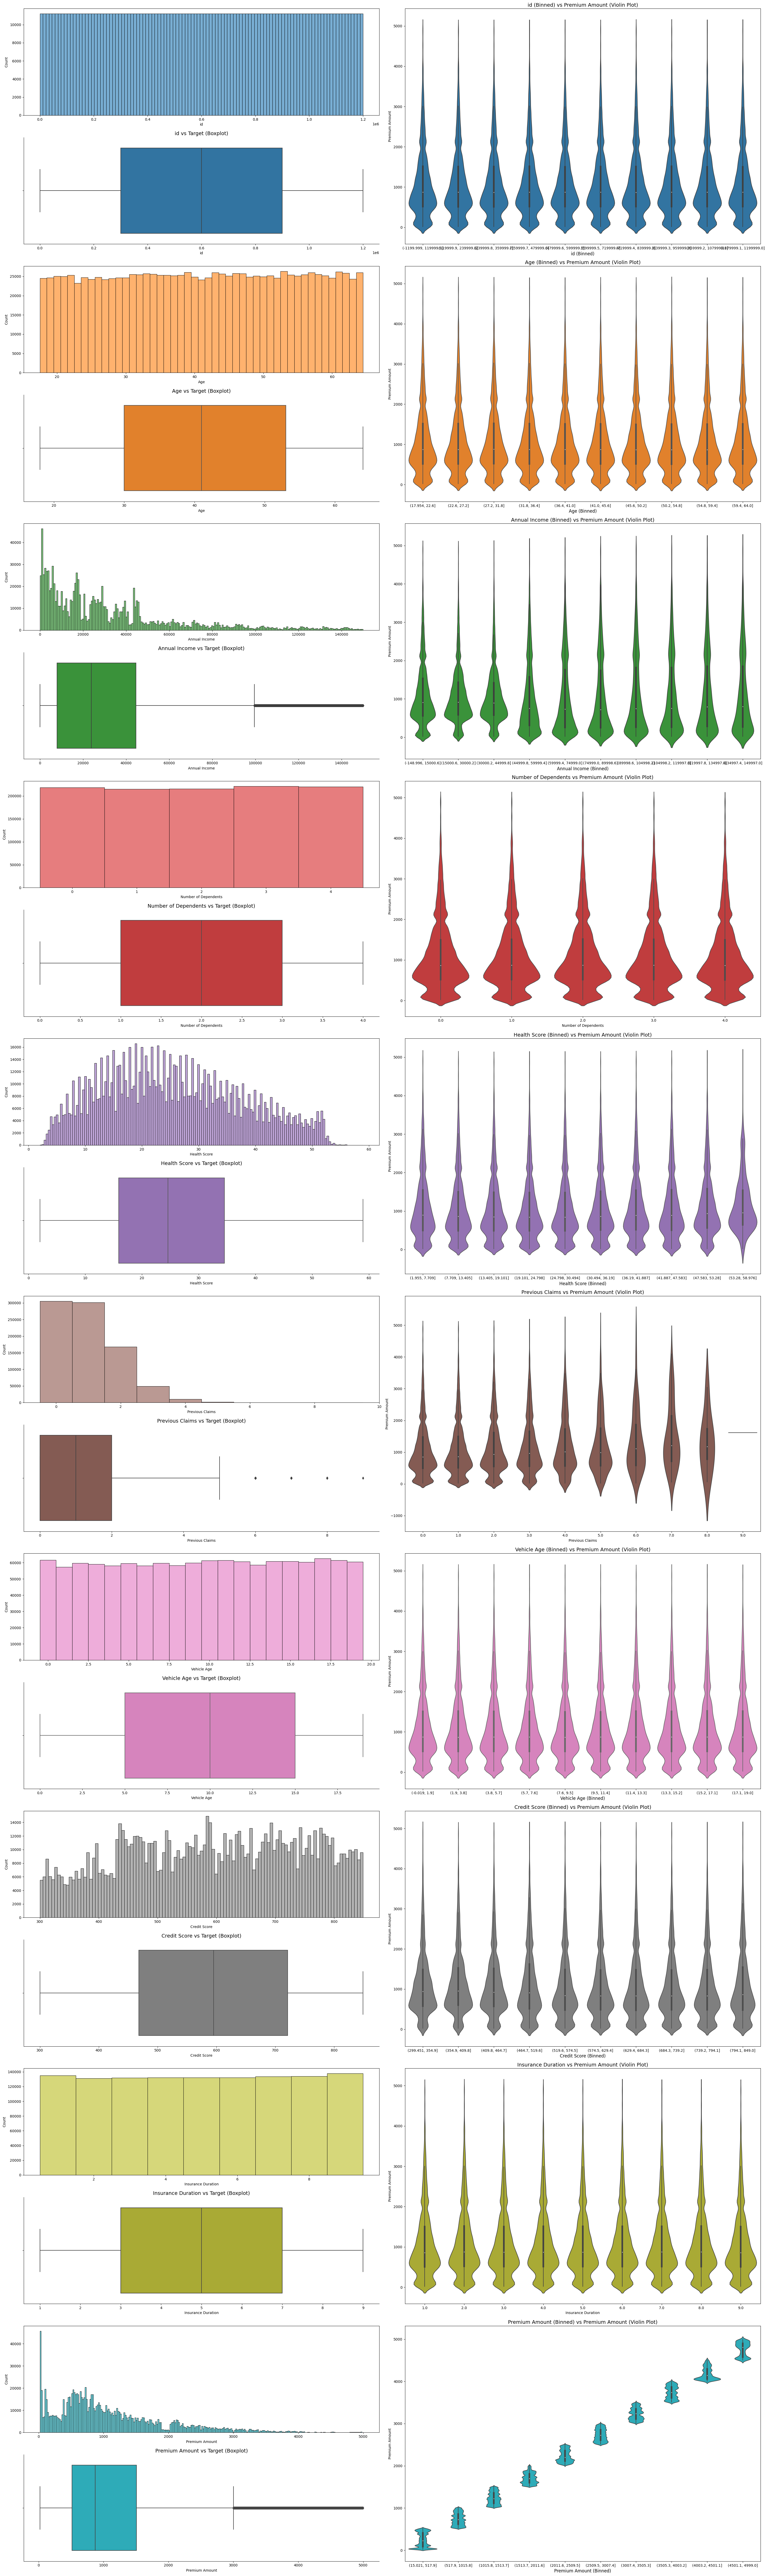

In [15]:

# Create a color palette for the columns
palette = sns.color_palette('tab10', len(numerical_columns))
color_dict = dict(zip(numerical_columns, palette))

# Create a grid of subplots for histograms, boxplots, and scatterplots/violin plots
fig = plt.figure(figsize=(30, 10 * len(numerical_columns)))
gs = gridspec.GridSpec(2 * len(numerical_columns), 2, figure=fig)

df_binned = train_df.copy()

for i, column in enumerate(numerical_columns):

    if train_df[column].nunique() > 50: discrete = False
    else : discrete = True
    
    # Plot histogram with a unique color
    ax_hist = fig.add_subplot(gs[2 * i, 0])
    sns.histplot(
        data=train_df, x=column, fill=True, common_norm=False, alpha=0.6,
        linewidth=0.8, color=color_dict[column], ax=ax_hist,  discrete = discrete
    )
    
    # Plot boxplot with the same unique color
    ax_box = fig.add_subplot(gs[2 * i + 1, 0])
    sns.boxplot(data=train_df, x=column, ax=ax_box, color=color_dict[column])
    ax_box.set_title(f'{column} vs Target (Boxplot)', fontsize=14)
    sns.despine(ax=ax_box)

    # Conditional plot: violin plot or barplot based on unique values, fallback to scatterplot
    ax_conditional = fig.add_subplot(gs[2 * i:2 * i + 2, 1])  # Merges 2 rows
    if train_df[column].nunique() <= 10:
        # If the column has 10 or fewer unique values, use a violin plot
        sns.violinplot(data=train_df, x=column, y=target_column, ax=ax_conditional, color=color_dict[column], alpha=0.6)
        ax_conditional.set_title(f'{column} vs {target_column} (Violin Plot)', fontsize=14)
    else:
        # Bin the column into 10 intervals, but keep original target column values
        df_binned['Binned Column'] = pd.cut(train_df[column], bins=10)
        sns.violinplot(data=df_binned, x='Binned Column', y=target_column, ax=ax_conditional, color=color_dict[column], alpha=0.6)
        ax_conditional.set_title(f'{column} (Binned) vs {target_column} (Violin Plot)', fontsize=14)
        ax_conditional.set_xlabel(f'{column} (Binned)', fontsize=12)

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

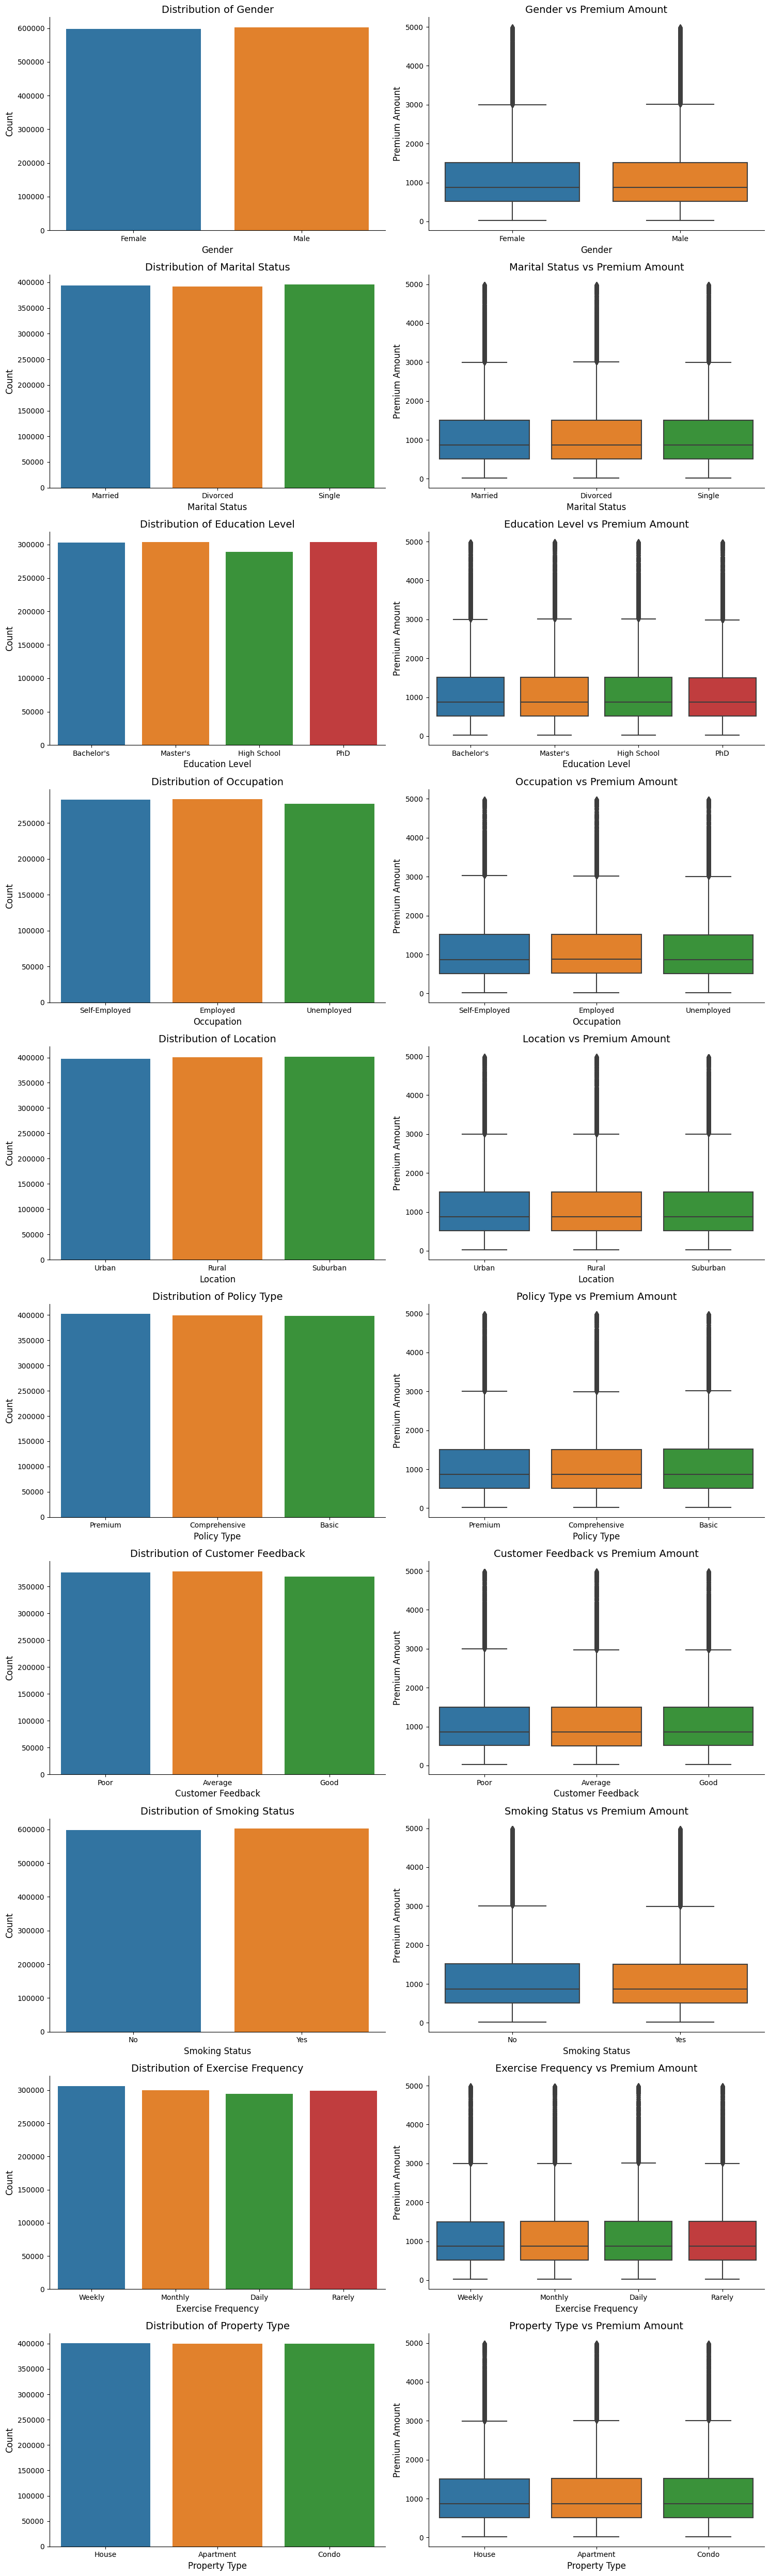

In [16]:
# Filtrer les colonnes catégorielles et exclure 'Policy Start Date'
filtered_columns = [col for col in categorical_columns if col != 'Policy Start Date']

# Créer des sous-graphiques pour barplots et boxplots
fig, axes = plt.subplots(len(filtered_columns), 2, figsize=(15, 5 * len(filtered_columns)))

for i, column in enumerate(filtered_columns):
    # Barplot à gauche
    sns.countplot(data=train_df, x=column, ax=axes[i, 0], palette='tab10')
    axes[i, 0].set_title(f'Distribution of {column}', fontsize=14)
    axes[i, 0].set_xlabel(column, fontsize=12)
    axes[i, 0].set_ylabel('Count', fontsize=12)
    sns.despine(ax=axes[i, 0])

    # Boxplot à droite
    sns.boxplot(data=train_df, x=column, y=target_column, ax=axes[i, 1], palette='tab10')
    axes[i, 1].set_title(f'{column} vs {target_column}', fontsize=14)
    axes[i, 1].set_xlabel(column, fontsize=12)
    axes[i, 1].set_ylabel(target_column, fontsize=12)
    sns.despine(ax=axes[i, 1])

plt.tight_layout()  # Ajustement global des sous-graphiques
plt.show()


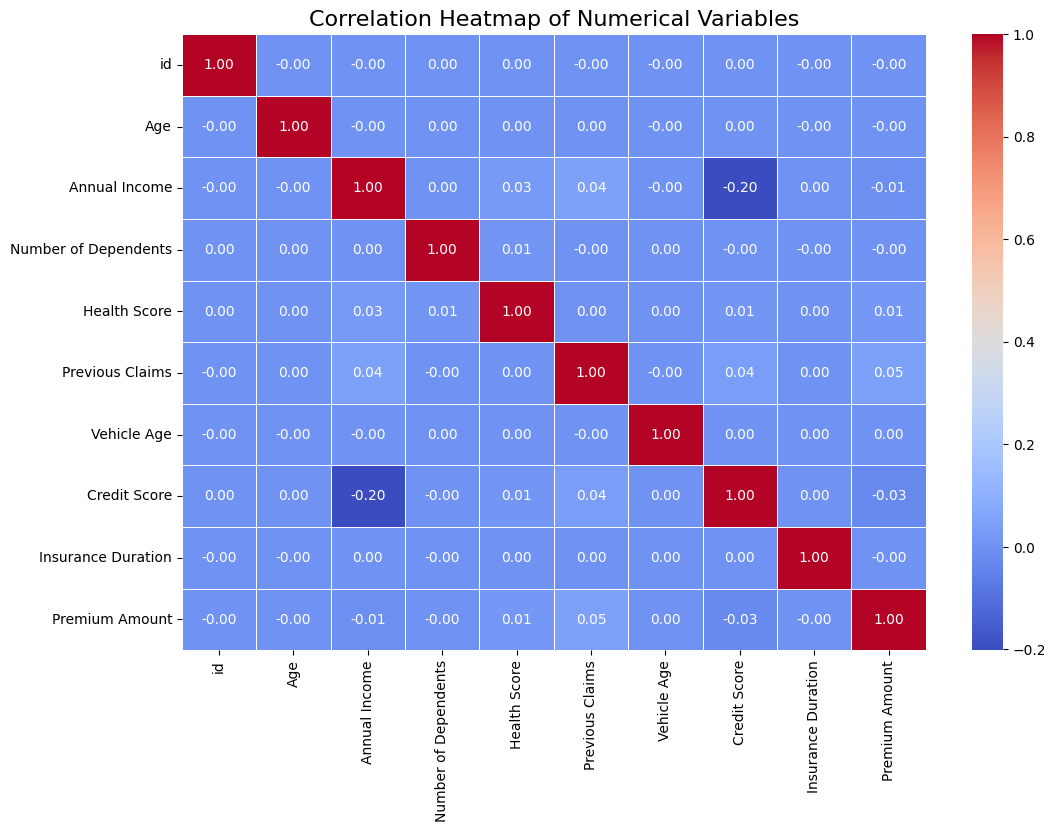

In [17]:
# Calculate the correlation matrix
correlation_matrix = train_df[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Variables", fontsize=16)
plt.show()


# Preprocessing

In [18]:
def date(df):

    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Month_name'] = df['Policy Start Date'].dt.month_name()
    df['Day_of_week'] = df['Policy Start Date'].dt.day_name()
    df['Week'] = df['Policy Start Date'].dt.isocalendar().week
    df['Year_sin'] = np.sin(2 * np.pi * df['Year'])
    df['Year_cos'] = np.cos(2 * np.pi * df['Year'])
    min_year = df['Year'].min()
    max_year = df['Year'].max()
    df['Year_sin'] = np.sin(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Year_cos'] = np.cos(2 * np.pi * (df['Year'] - min_year) / (max_year - min_year))
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12) 
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)  
    df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    df['Group']=(df['Year']-2020)*48+df['Month']*4+df['Day']//7
    
    df.drop('Policy Start Date', axis=1, inplace=True)

    return df

In [19]:
# Apply the date function to both datasets
train_df = date(train_df)
test_df = date(test_df)

In [20]:
# Define features and target
numerical_features = [
    'Age', 'Annual Income', 'Number of Dependents', 'Health Score', 
    'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 
    'Year_sin', 'Year_cos', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos'
]
categorical_features = [
    'Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
    'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 
    'Property Type', 'Month_name', 'Day_of_week'
]
target_column = 'Premium Amount'

In [21]:
# Split train data into features and target
X = train_df.drop(columns=[target_column, 'id', 'Group', 'Year', 'Month', 'Day', 'Week'])
y = train_df[target_column]

In [22]:
# Handle missing values
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [23]:
# Preprocess train and test data
X_processed = preprocessor.fit_transform(X)
test_processed = preprocessor.transform(test_df.drop(columns=['id', 'Group', 'Year', 'Month', 'Day', 'Week']))

In [24]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Model Training

In [25]:

"""
# Define Optuna optimization function
def objective(trial):
    # Define parameter search space
    param = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int("num_leaves", 200, 512),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "max_depth": trial.suggest_int("max_depth", -1, 16),  # -1 means no limit
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-4, 10.0),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-4, 10.0),
        "device_type": "gpu",  # Enable GPU support
        "seed" : 42

    }

    # Create a LightGBM dataset
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val, reference=dtrain)

    # Train LightGBM model
    model = lgb.train(
        param,
        dtrain,
        valid_sets=[dval],
    )

    # Predict on validation set
    y_val_pred = model.predict(X_val)
    
    # Compute RMSLE using sklearn's root_mean_squared_log_error
    rmsle = root_mean_squared_log_error(y_val, np.maximum(y_val_pred, 0))
    return rmsle

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200)
"""

'\n# Define Optuna optimization function\ndef objective(trial):\n    # Define parameter search space\n    param = {\n        "objective": "regression",\n        "metric": "rmse",\n        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),\n        "num_leaves": trial.suggest_int("num_leaves", 200, 512),\n        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),\n        "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),\n        "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.6, 1.0),\n        "bagging_freq": trial.suggest_int("bagging_freq", 5, 12),\n        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),\n        "max_depth": trial.suggest_int("max_depth", -1, 16),  # -1 means no limit\n        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-4, 10.0),\n        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-4, 10.0),\n        "device_type": "gpu",  # Enable GPU supp

In [26]:
# Initialize or update the best_params dictionary
best_params = {
    'boosting_type': 'dart',
    'num_leaves': 384,
    'learning_rate': 0.024680120465142227,
    'feature_fraction': 0.9883068358315126,
    'bagging_fraction': 0.7201712704805496,
    'bagging_freq': 7,
    'min_data_in_leaf': 50,
    'max_depth': 15,
    'lambda_l1': 0.0011290211269753322,
    'lambda_l2': 3.056310541294088,
    'seed': 42
}

# Submission

In [27]:
preprocessor.get_feature_names_out()

array(['num__Age', 'num__Annual Income', 'num__Number of Dependents',
       'num__Health Score', 'num__Previous Claims', 'num__Vehicle Age',
       'num__Credit Score', 'num__Insurance Duration', 'num__Year_sin',
       'num__Year_cos', 'num__Month_sin', 'num__Month_cos',
       'num__Day_sin', 'num__Day_cos', 'cat__Gender_Female',
       'cat__Gender_Male', 'cat__Marital Status_Divorced',
       'cat__Marital Status_Married', 'cat__Marital Status_Single',
       'cat__Marital Status_nan', "cat__Education Level_Bachelor's",
       'cat__Education Level_High School',
       "cat__Education Level_Master's", 'cat__Education Level_PhD',
       'cat__Occupation_Employed', 'cat__Occupation_Self-Employed',
       'cat__Occupation_Unemployed', 'cat__Occupation_nan',
       'cat__Location_Rural', 'cat__Location_Suburban',
       'cat__Location_Urban', 'cat__Policy Type_Basic',
       'cat__Policy Type_Comprehensive', 'cat__Policy Type_Premium',
       'cat__Customer Feedback_Average', 'cat__Cu

In [28]:
# Print best parameters
#print("Best parameters:", study.best_params)

# Train final model with best parameters
#best_params = study.best_params

final_model = lgb.train(
    best_params,
    lgb.Dataset(X_processed, label=y),
)

# Make predictions on the test set
test_predictions = final_model.predict(test_processed, num_iteration=final_model.best_iteration)

# Prepare submission file
submission = pd.DataFrame({'id': test_df['id'], 'Premium Amount': test_predictions})
submission.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1052
[LightGBM] [Info] Number of data points in the train set: 1200000, number of used features: 66
[LightGBM] [Info] Start training from score 1102.544822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Submission file created: submission.csv



Performance Metrics:
------------------------------
RMSLE: 1.0634
RMSE: 906.9466
MAE: 625.4777
R²: -0.0993
MAPE: 204.97%


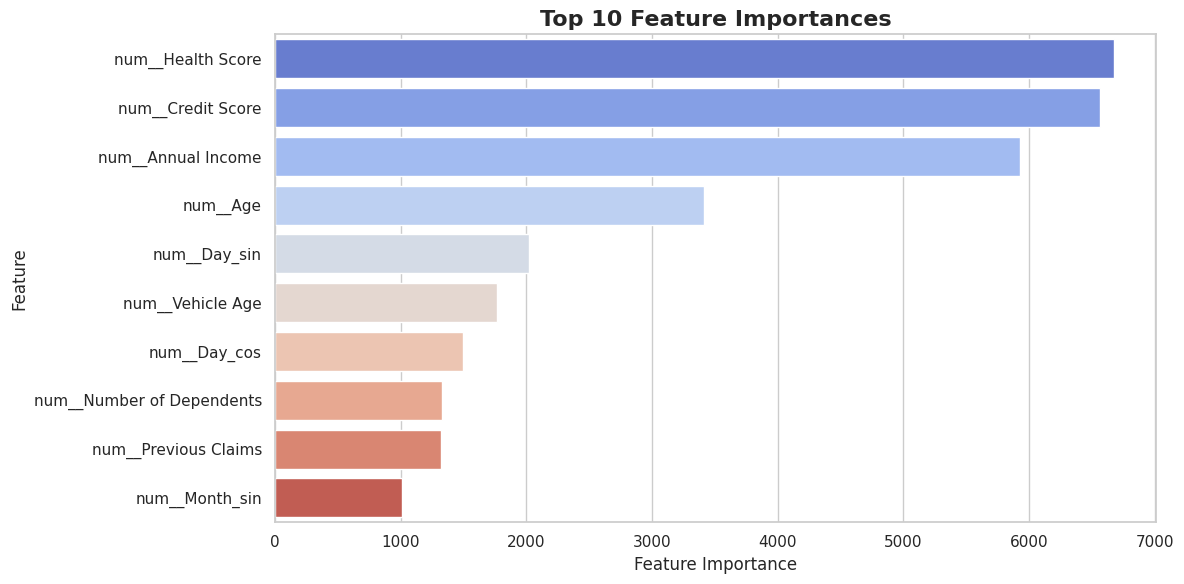

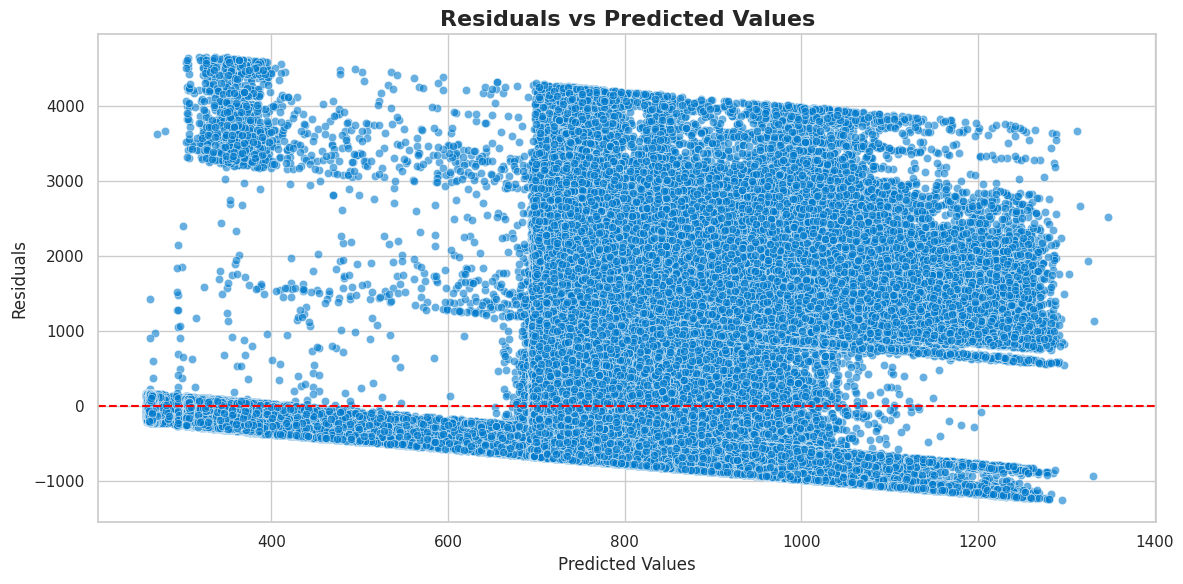

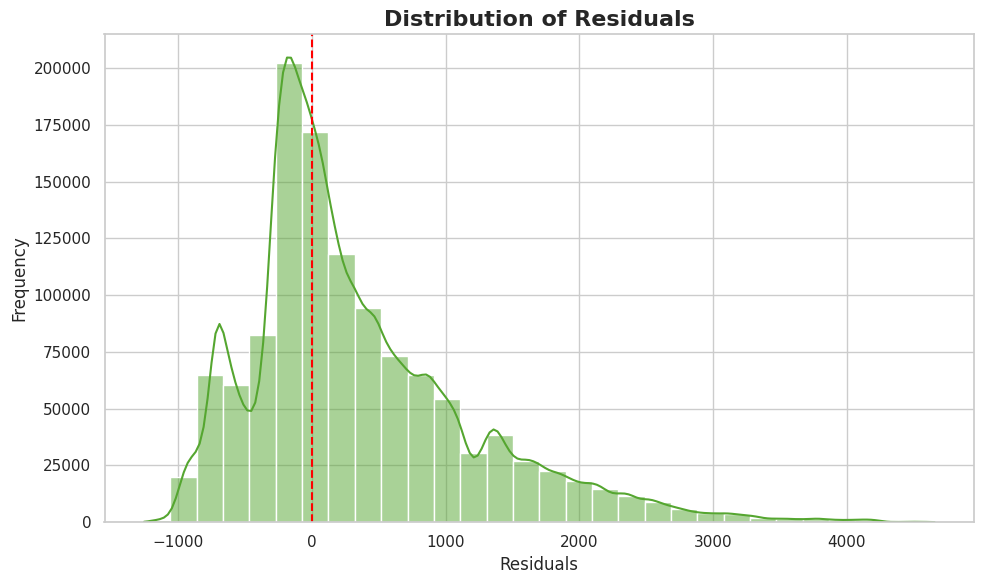

In [29]:
# Set a cohesive Seaborn style
sns.set_theme(style="whitegrid")

# 1. Performance Metrics
y_pred = final_model.predict(X_processed)

# Calcul des métriques
rmsle = root_mean_squared_log_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)
mape = np.mean(np.abs((y - y_pred) / y)) * 100

# Display performance metrics
print(f"\nPerformance Metrics:\n{'-'*30}")
print(f"RMSLE: {rmsle:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# 2. Feature Importance
importances = final_model.feature_importance(importance_type='split')  # or 'gain'
features = preprocessor.get_feature_names_out()
sorted_indices = importances.argsort()[::-1]

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': [features[i] for i in sorted_indices],
    'Importance': importances[sorted_indices]
})

# Plot top 10 feature importances
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette="coolwarm")
plt.title("Top 10 Feature Importances", fontsize=16, fontweight='bold')
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

# 3. Residual Analysis
residuals = y - y_pred

# Residuals vs Predicted Values
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, color="#007acc")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Residuals vs Predicted Values", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.tight_layout()
plt.show()

# Residual Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color="#55a630")
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Distribution of Residuals", fontsize=16, fontweight='bold')
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()
